In [1]:
# libraries used for data exploration
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from skimpy import skim

# librairies used for machine learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction import DictVectorizer
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.tree import DecisionTreeRegressor, export_text

# utils
import gc
from scipy.stats import randint

import warnings
warnings.filterwarnings('ignore')

In [2]:
PATH = "../datasets/dataset.csv"

In [3]:
df = pd.read_csv(PATH)
df.head()

,Marque,Modèle,Energie,Carrosserie,Cylindrée,Gamme,Puissance fiscale,Puissance maximale,Puissance nominale électrique,Poids à vide,...,Bonus-Malus,Conso basse vitesse,Conso moyenne vitesse,Conso haute vitesse,Conso T-haute vitesse,Conso vitesse mixte,Conso elec,Autonomie elec,Autonomie elec urbain,Emission CO2
0,renault,kangoo,essence,combispace,1332,inferieure,7,96.0,NaN,1519,...,malus,8.7405,6.7880,6.188,7.9175,7.2635,NaN,NaN,NaN,167.272
1,mazda,mx-30,electric,ts_terrains/chemins,0,inferieure,6,NaN,80.9,1645,...,bonus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ds,7_crossback,elec+essenc_hr,ts_terrains/chemins,1598,moyenne_superieure,10,133.0,30.0,1760,...,neutre,NaN,NaN,NaN,NaN,1.5340,162.5,58.5,67.5,NaN
3,renault,austral,ess+elec_hnr,ts_terrains/chemins,1199,moyenne_superieure,7,96.0,0.0,1421,...,neutre,6.5805,5.0200,4.834,5.9555,5.5025,NaN,NaN,NaN,126.073
4,b.m.w.,218,essence,monospace_compact,1499,moyenne_inferieure,7,100.0,NaN,1470,...,malus,8.9420,6.6295,5.637,6.4505,6.5680,NaN,NaN,NaN,155.826


In [4]:
df.shape

(7679, 23)

In [5]:
skim(df)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 7679   │ │ float64     │ 12    │                                                          │
│ │ Number of columns │ 23     │ │ string      │ 7     │                                                          │
│ └───────────────────┴────────┘ │ int32       │ 4     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name             ┃ NA    ┃ NA %   ┃ mean   ┃ sd     ┃ p0    ┃ p25   ┃ p50   ┃ p75   ┃ p100 ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━━┩  │
│ │ Cylindrée               │     0 │      0 │   1700 │    680 │     0 │  1400 │  1600 │  2000 │ 6700 │  ▂▇▁   │  │
│ │ Puissance fiscale       │     0 │      0 │     10 │    7.7 │     1 │     6 │     8 │    10 │   91 │   ▇▁   │  │
│ │ Puissance maximale      │   269 │    3.5 │    130 │     66 │    48 │    92 │   110 │   140 │  610 │  ▇▂▁   │  │
│ │ Puissance nominale      │  4925 │  64.14 │     25 │     32 │     0 │     0 │    10 │    48 │  200 │  ▇▂▁   │  │
│ │ électrique              │       │        │        │        │       │       │       │       │      │        │  │
│ │ Poids à vide            │     0 │      0 │   1600 │    340 │   840 │  1300 │  1500 │  1800 │ 2700 │ ▂▇▆▃▁  │  │
│ │ Rapport poids-puissance │     0 │      0 │  0.079 │  0.035 │     0 │  0.06 │  0.07 │  0.09 │ 0.37 │  ▃▇▁   │  │
│ │ Nombre rapports         │     0 │      0 │    6.7 │    1.9 │     0 │     6 │     7 │     8 │    9 │ ▁   ▇▆ │  │
│ │ Conso basse vitesse     │   989 │  12.88 │      8 │    2.2 │   3.2 │   6.7 │   7.8 │   8.9 │   30 │   ▇▇   │  │
│ │ Conso moyenne vitesse   │   989 │  12.88 │    6.1 │    1.3 │   3.3 │   5.2 │   5.9 │   6.7 │   18 │  ▆▇▁   │  │
│ │ Conso haute vitesse     │   989 │  12.88 │    5.4 │      1 │   3.7 │   4.7 │   5.3 │   5.8 │   14 │  ▇▆▁   │  │
│ │ Conso T-haute vitesse   │   989 │  12.88 │    6.5 │    1.1 │   4.2 │   5.7 │   6.3 │     7 │   14 │  ▅▇▂   │  │
│ │ Conso vitesse mixte     │   395 │   5.14 │    5.9 │    1.7 │  0.56 │   5.2 │     6 │   6.8 │   17 │  ▁▆▇   │  │
│ │ Conso elec              │  6861 │  89.35 │    200 │     42 │   130 │   160 │   190 │   240 │  290 │ ▇▇▅▃▆▂ │  │
│ │ Autonomie elec          │  6861 │  89.35 │    140 │    140 │    40 │    50 │    64 │   120 │  680 │  ▇ ▁▁  │  │
│ │ Autonomie elec urbain   │  6861 │  89.35 │    170 │    180 │    41 │    55 │    74 │   170 │  740 │ ▇  ▁▁  │  │
│ │ Emission CO2            │   989 │  12.88 │    150 │     31 │    93 │   140 │   150 │   160 │  410 │  ▇▇▁   │  │
│ └─────────────────────────┴───────┴────────┴────────┴────────┴───────┴───────┴───────┴───────┴──────┴────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name                  ┃ NA     ┃ NA %       ┃ words per row               ┃ total words             ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━╇

In [6]:
# remove electric vehicles
df = df[df["Energie"] != 'electric']

In [7]:
df.shape

(7409, 23)

In [8]:
df.describe()

,Cylindrée,Puissance fiscale,Puissance maximale,Puissance nominale électrique,Poids à vide,Rapport poids-puissance,Nombre rapports,Conso basse vitesse,Conso moyenne vitesse,Conso haute vitesse,Conso T-haute vitesse,Conso vitesse mixte,Conso elec,Autonomie elec,Autonomie elec urbain,Emission CO2
count,7409.000000,7409.000000,7409.000000,2484.000000,7409.000000,7409.000000,7409.000000,6690.000000,6690.000000,6690.000000,6690.000000,7284.000000,594.000000,594.000000,594.000000,6690.000000
mean,1796.202322,10.229856,130.021055,20.157009,1555.344986,0.082061,6.928195,8.018916,6.075571,5.407636,6.464161,5.897295,199.928636,61.744613,68.052020,154.651505
std,609.909070,7.806961,66.386992,27.228414,333.232021,0.031618,1.553918,2.238887,1.254111,1.027638,1.135738,1.719087,40.243956,18.477725,19.951523,30.739784
min,875.000000,4.000000,48.000000,0.000000,840.000000,0.040000,0.000000,3.219000,3.327000,3.726000,4.238500,0.562000,133.500000,39.700000,41.350000,92.947000
25%,1469.000000,6.000000,91.900000,0.000000,1320.000000,0.060000,6.000000,6.663000,5.213500,4.709000,5.655000,5.243500,162.500000,48.000000,51.750000,135.540000
50%,1950.000000,8.000000,110.000000,8.000000,1490.000000,0.080000,7.000000,7.765000,5.912500,5.267500,6.296000,5.987000,192.850000,56.000000,61.000000,147.635000
75%,1995.000000,10.000000,140.000000,30.000000,1755.000000,0.090000,8.000000,8.862500,6.675500,5.840500,7.025000,6.752500,241.770000,74.000000,87.000000,164.659250
max,6749.000000,91.000000,607.000000,139.000000,2735.000000,0.370000,9.000000,29.914500,17.541500,13.632000,13.947000,16.521500,288.500000,112.000000,116.500000,411.010000


In [9]:
categorical = list(df.dtypes[df.dtypes == 'object'].index)

In [10]:
numerical = [i for i in list(df.columns) if i not in categorical]
numerical.pop(-1)

'Emission CO2'

In [11]:
df.columns

Index(['Marque', 'Modèle', 'Energie', 'Carrosserie', 'Cylindrée', 'Gamme',
       'Puissance fiscale', 'Puissance maximale',
       'Puissance nominale électrique', 'Poids à vide',
       'Rapport poids-puissance', 'Type de boite', 'Nombre rapports',
       'Bonus-Malus', 'Conso basse vitesse', 'Conso moyenne vitesse',
       'Conso haute vitesse', 'Conso T-haute vitesse', 'Conso vitesse mixte',
       'Conso elec', 'Autonomie elec', 'Autonomie elec urbain',
       'Emission CO2'],
      dtype='object')

In [12]:
# fill variables about electric consumption
df["Autonomie elec"] = df["Autonomie elec"].fillna(0)
df["Puissance nominale électrique"] = df["Puissance nominale électrique"].fillna(0)
df["Conso elec"] = df["Conso elec"].fillna(0)
df["Autonomie elec urbain"] = df["Autonomie elec urbain"].fillna(0)

In [13]:
# fill other numerical variables
for c in numerical:
    df[c] = df[c].fillna(df[c].median())

In [14]:
# fill target variable
df["Emission CO2"] = df["Emission CO2"].fillna(df["Emission CO2"].median())

In [15]:
skim(df)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 7409   │ │ float64     │ 12    │                                                          │
│ │ Number of columns │ 23     │ │ string      │ 7     │                                                          │
│ └───────────────────┴────────┘ │ int32       │ 4     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━┳━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name              ┃ NA  ┃ NA %  ┃ mean    ┃ sd     ┃ p0    ┃ p25   ┃ p50   ┃ p75   ┃ p100  ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━╇━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━┩  │
│ │ Cylindrée                │   0 │     0 │    1800 │    610 │   880 │  1500 │  2000 │  2000 │  6700 │  ▇▆▁   │  │
│ │ Puissance fiscale        │   0 │     0 │      10 │    7.8 │     4 │     6 │     8 │    10 │    91 │   ▇▁   │  │
│ │ Puissance maximale       │   0 │     0 │     130 │     66 │    48 │    92 │   110 │   140 │   610 │  ▇▂▁   │  │
│ │ Puissance nominale       │   0 │     0 │     6.8 │     18 │     0 │     0 │     0 │     0 │   140 │   ▇    │  │
│ │ électrique               │     │       │         │        │       │       │       │       │       │        │  │
│ │ Poids à vide             │   0 │     0 │    1600 │    330 │   840 │  1300 │  1500 │  1800 │  2700 │ ▂▇▆▃▁  │  │
│ │ Rapport poids-puissance  │   0 │     0 │   0.082 │  0.032 │  0.04 │  0.06 │  0.08 │  0.09 │  0.37 │   ▇▁   │  │
│ │ Nombre rapports          │   0 │     0 │     6.9 │    1.6 │     0 │     6 │     7 │     8 │     9 │     ▇▆ │  │
│ │ Conso basse vitesse      │   0 │     0 │       8 │    2.1 │   3.2 │   6.8 │   7.8 │   8.7 │    30 │   ▆▇   │  │
│ │ Conso moyenne vitesse    │   0 │     0 │     6.1 │    1.2 │   3.3 │   5.3 │   5.9 │   6.6 │    18 │   ▅▇   │  │
│ │ Conso haute vitesse      │   0 │     0 │     5.4 │   0.98 │   3.7 │   4.8 │   5.3 │   5.8 │    14 │   ▇▅   │  │
│ │ Conso T-haute vitesse    │   0 │     0 │     6.4 │    1.1 │   4.2 │   5.7 │   6.3 │   6.9 │    14 │  ▅▇▂   │  │
│ │ Conso vitesse mixte      │   0 │     0 │     5.9 │    1.7 │  0.56 │   5.3 │     6 │   6.7 │    17 │  ▁▆▇   │  │
│ │ Conso elec               │   0 │     0 │      16 │     55 │     0 │     0 │     0 │     0 │   290 │   ▇    │  │
│ │ Autonomie elec           │   0 │     0 │       5 │     18 │     0 │     0 │     0 │     0 │   110 │   ▇    │  │
│ │ Autonomie elec urbain    │   0 │     0 │     5.5 │     19 │     0 │     0 │     0 │     0 │   120 │   ▇    │  │
│ │ Emission CO2             │   0 │     0 │     150 │     29 │    93 │   140 │   150 │   160 │   410 │  ▆▇▁   │  │
│ └──────────────────────────┴─────┴───────┴─────────┴────────┴───────┴───────┴───────┴───────┴───────┴────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name                  ┃ NA     ┃ NA %       ┃ words per row               ┃ total words             ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━╇

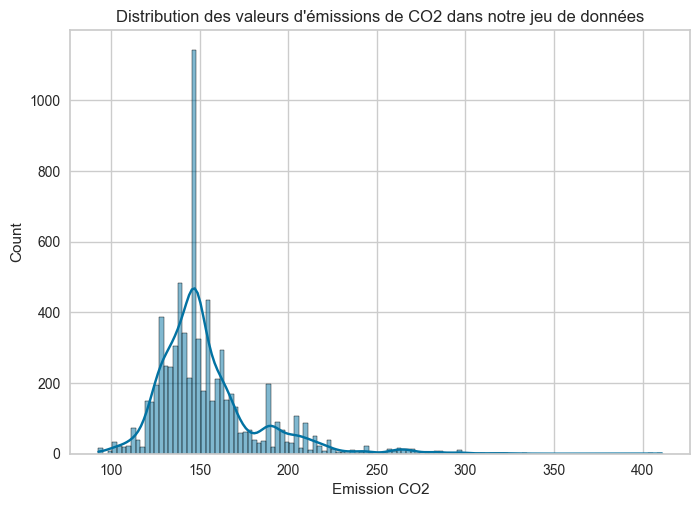

In [16]:
sns.histplot(
    data = df,
    x = "Emission CO2",
    kde=True
)
plt.title("Distribution des valeurs d'émissions de CO2 dans notre jeu de données")
plt.show()

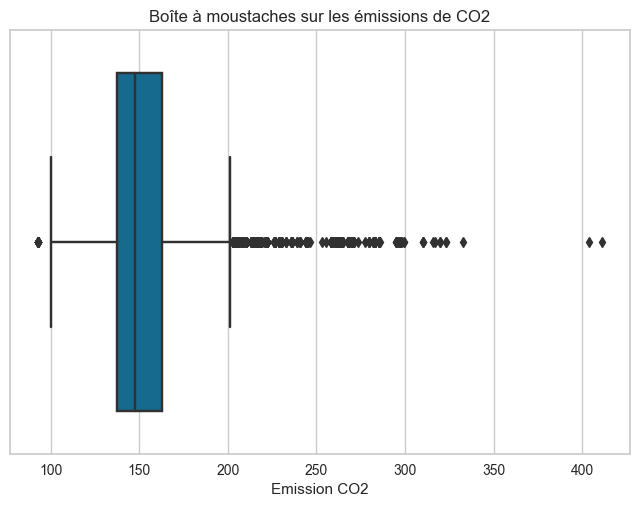

In [17]:
sns.boxplot(
    x="Emission CO2",
    data=df
)
plt.title('Boîte à moustaches sur les émissions de CO2')
plt.show()

In [18]:
df["Emission CO2"].describe()

count    7409.000000
mean      153.970594
std        29.283719
min        92.947000
25%       137.293000
50%       147.635000
75%       162.945000
max       411.010000
Name: Emission CO2, dtype: float64

In [19]:
df[df["Emission CO2"] == df["Emission CO2"].min()]

,Marque,Modèle,Energie,Carrosserie,Cylindrée,Gamme,Puissance fiscale,Puissance maximale,Puissance nominale électrique,Poids à vide,...,Bonus-Malus,Conso basse vitesse,Conso moyenne vitesse,Conso haute vitesse,Conso T-haute vitesse,Conso vitesse mixte,Conso elec,Autonomie elec,Autonomie elec urbain,Emission CO2
92,toyota,yaris,ess+elec_hnr,berline,1490,inferieure,5,68.0,37.0,1085,...,neutre,3.219,3.327,3.9015,5.7335,4.3435,0.0,0.0,0.0,92.947
728,toyota,yaris,ess+elec_hnr,berline,1490,inferieure,5,68.0,37.0,1085,...,neutre,3.219,3.327,3.9015,5.7335,4.3435,0.0,0.0,0.0,92.947
1858,toyota,yaris,ess+elec_hnr,berline,1490,inferieure,5,68.0,37.0,1090,...,neutre,3.219,3.327,3.9015,5.7335,4.3435,0.0,0.0,0.0,92.947
2415,toyota,yaris,ess+elec_hnr,berline,1490,inferieure,5,68.0,37.0,1090,...,neutre,3.219,3.327,3.9015,5.7335,4.3435,0.0,0.0,0.0,92.947
2642,toyota,yaris,ess+elec_hnr,berline,1490,inferieure,5,68.0,37.0,1085,...,neutre,3.219,3.327,3.9015,5.7335,4.3435,0.0,0.0,0.0,92.947
2691,toyota,yaris,ess+elec_hnr,berline,1490,inferieure,5,68.0,37.0,1090,...,neutre,3.219,3.327,3.9015,5.7335,4.3435,0.0,0.0,0.0,92.947
2750,toyota,yaris,ess+elec_hnr,berline,1490,inferieure,5,68.0,37.0,1090,...,neutre,3.219,3.327,3.9015,5.7335,4.3435,0.0,0.0,0.0,92.947
2789,toyota,yaris,ess+elec_hnr,berline,1490,inferieure,5,68.0,37.0,1090,...,neutre,3.219,3.327,3.9015,5.7335,4.3435,0.0,0.0,0.0,92.947
2974,toyota,yaris,ess+elec_hnr,berline,1490,inferieure,5,68.0,37.0,1130,...,neutre,3.219,3.327,3.9015,5.7335,4.3435,0.0,0.0,0.0,92.947
3873,toyota,yaris,ess+elec_hnr,berline,1490,inferieure,5,68.0,37.0,1090,...,neutre,3.219,3.327,3.9015,5.7335,4.3435,0.0,0.0,0.0,92.947


In [20]:
df[df["Emission CO2"] == df["Emission CO2"].max()]

,Marque,Modèle,Energie,Carrosserie,Cylindrée,Gamme,Puissance fiscale,Puissance maximale,Puissance nominale électrique,Poids à vide,...,Bonus-Malus,Conso basse vitesse,Conso moyenne vitesse,Conso haute vitesse,Conso T-haute vitesse,Conso vitesse mixte,Conso elec,Autonomie elec,Autonomie elec urbain,Emission CO2
205,rolls_royce,cullinan,essence,ts_terrains/chemins,6749,luxe,53,441.0,0.0,2710,...,malus,28.51,17.5415,13.632,13.947,16.5215,0.0,0.0,0.0,411.01


In [21]:
# log transformation
df["Emission CO2"] = np.log1p(df["Emission CO2"])

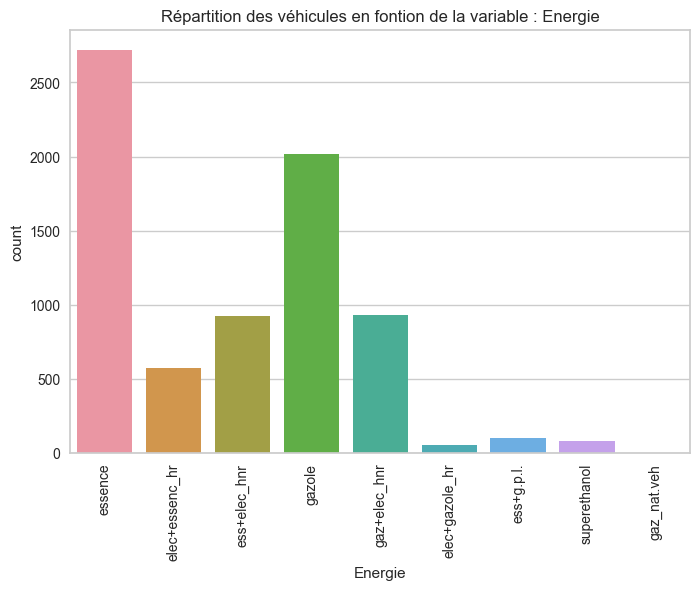

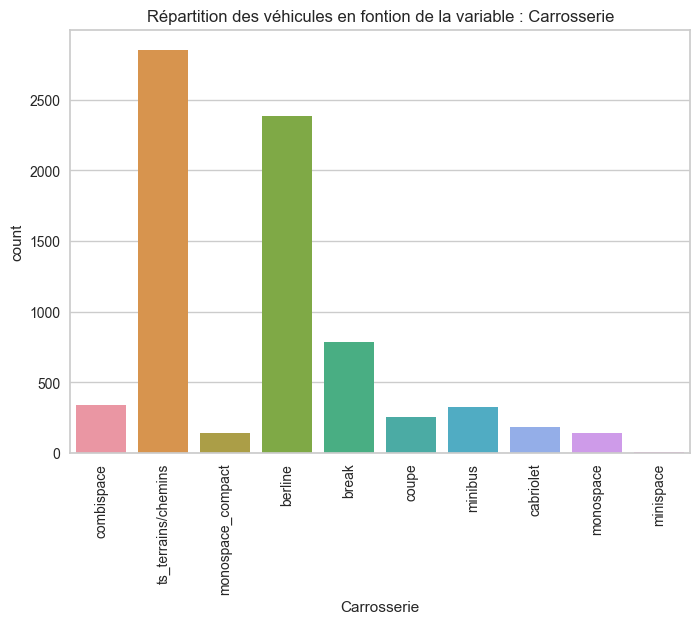

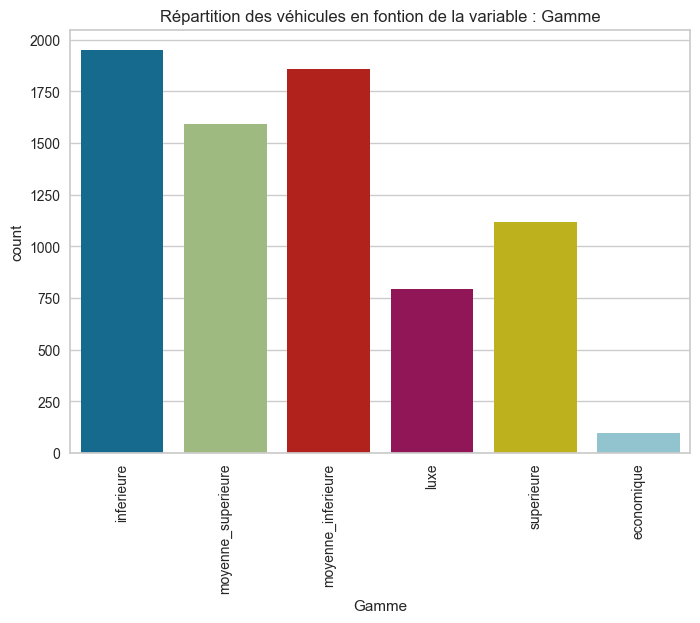

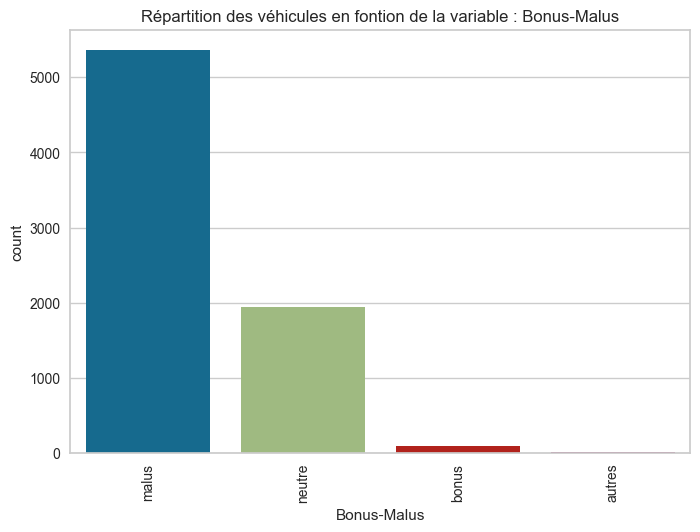

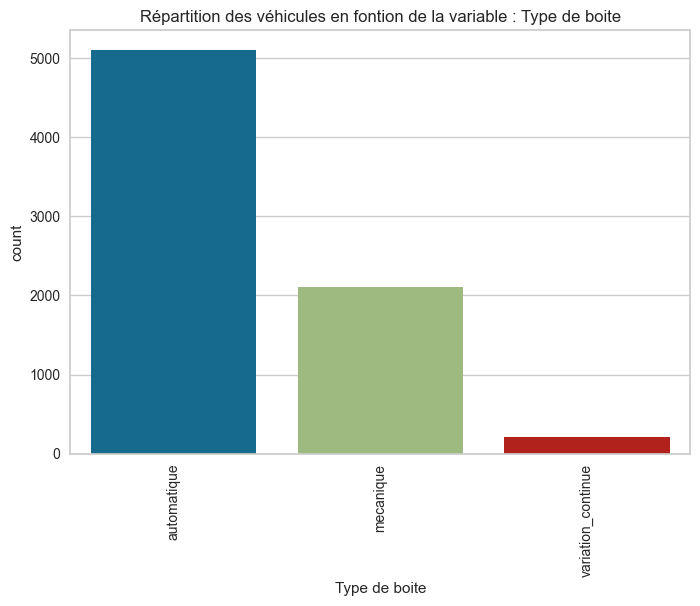

In [22]:
for col in ['Energie', 'Carrosserie', 'Gamme', 'Bonus-Malus', "Type de boite"]:
    sns.countplot(
        x=col,
        data=df
        )
    plt.title(f"Répartition des véhicules en fontion de la variable : {col}")
    plt.xticks(rotation=90)
    plt.show()

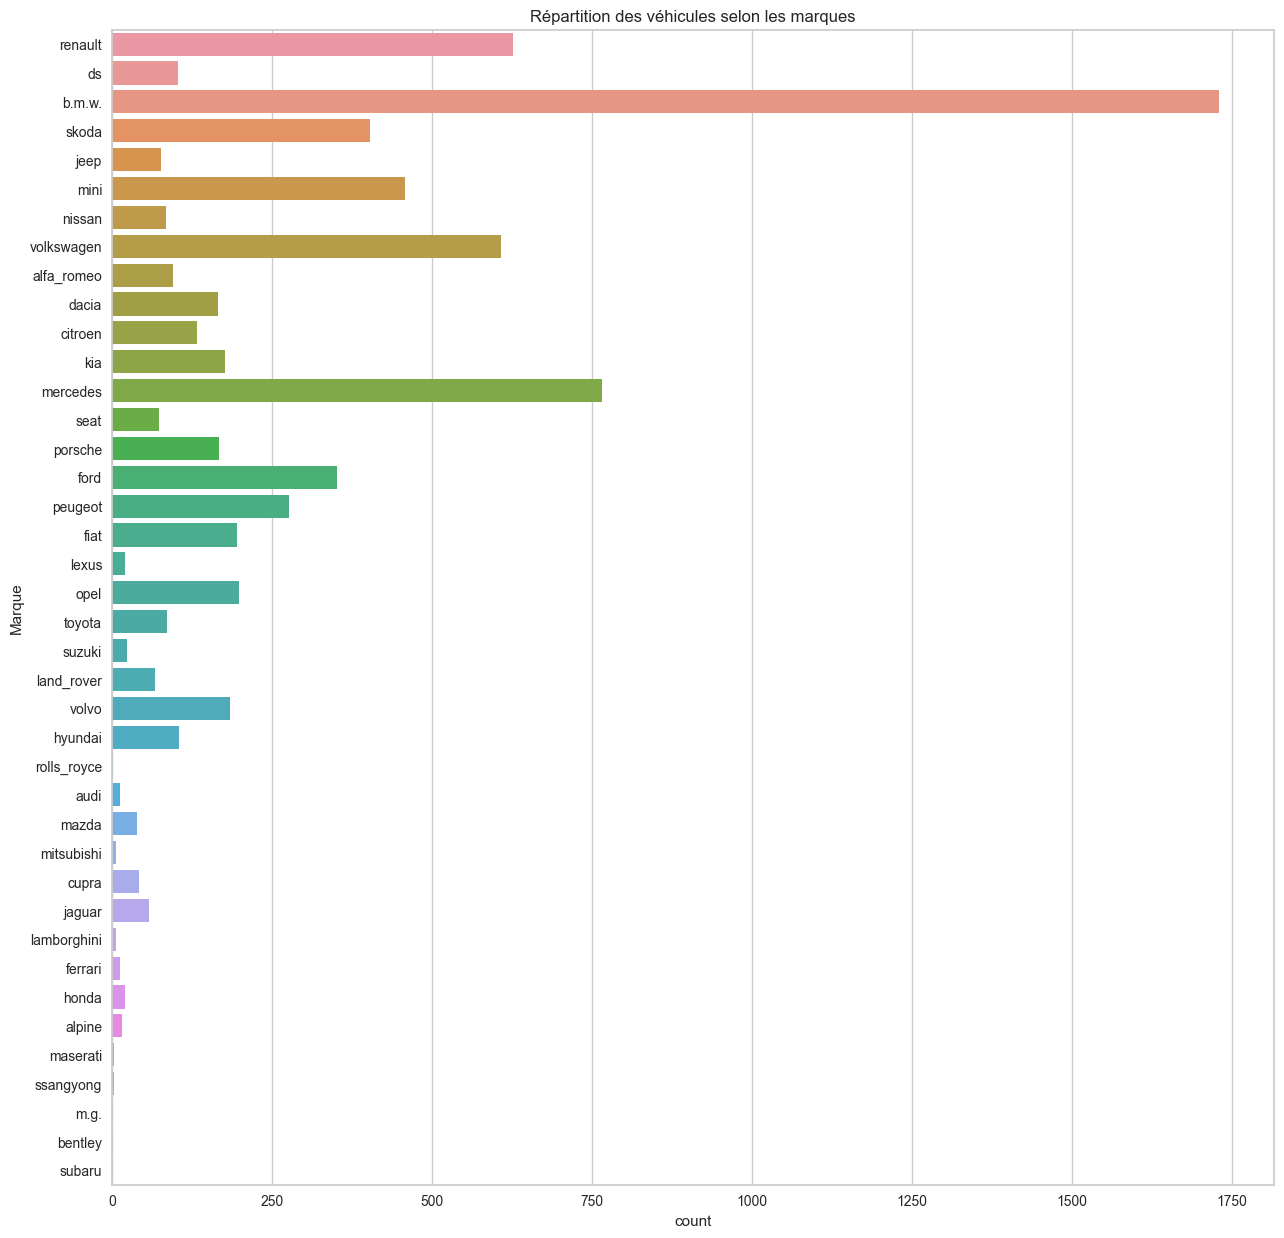

In [23]:
plt.figure(figsize=(15,15))

sns.countplot(
    y="Marque",
    data=df
)
plt.title(f"Répartition des véhicules selon les marques")
plt.show()

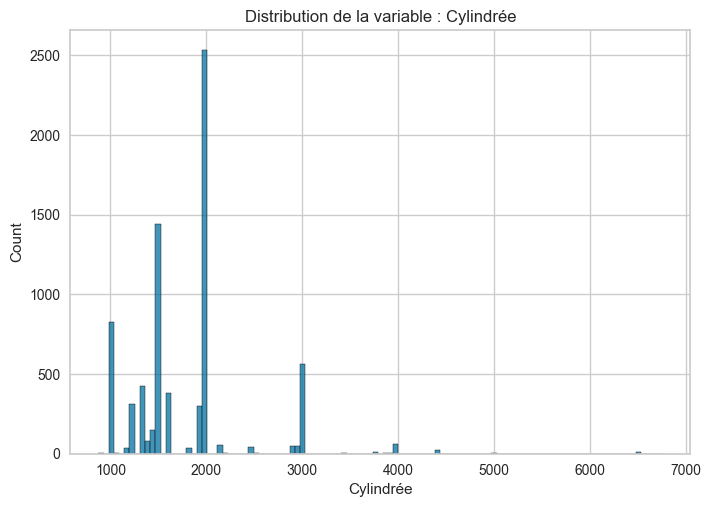

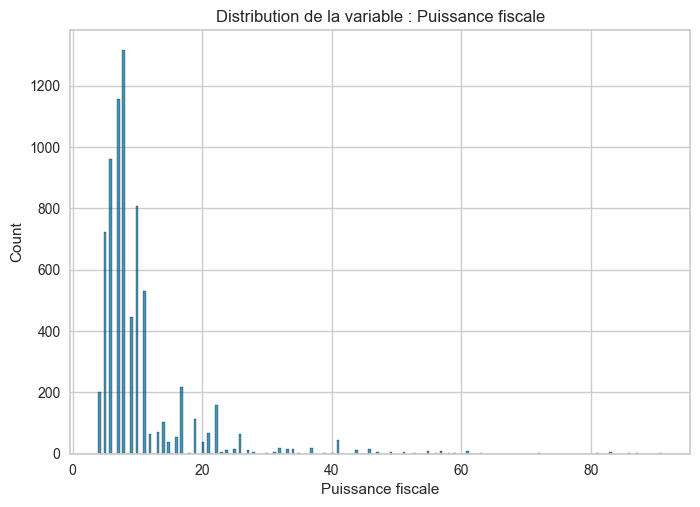

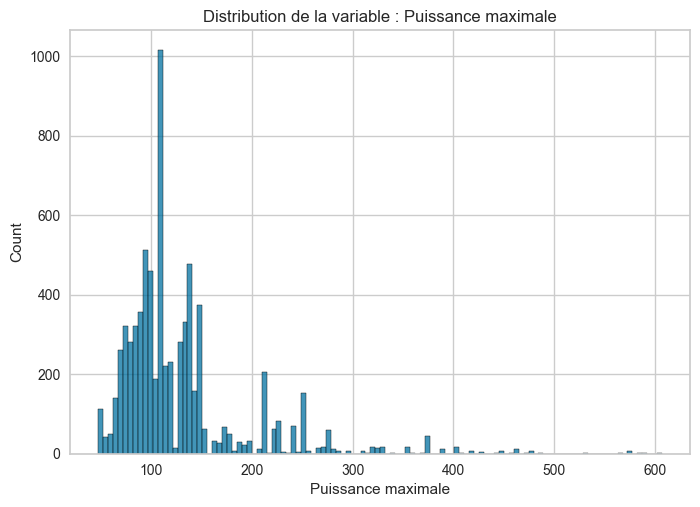

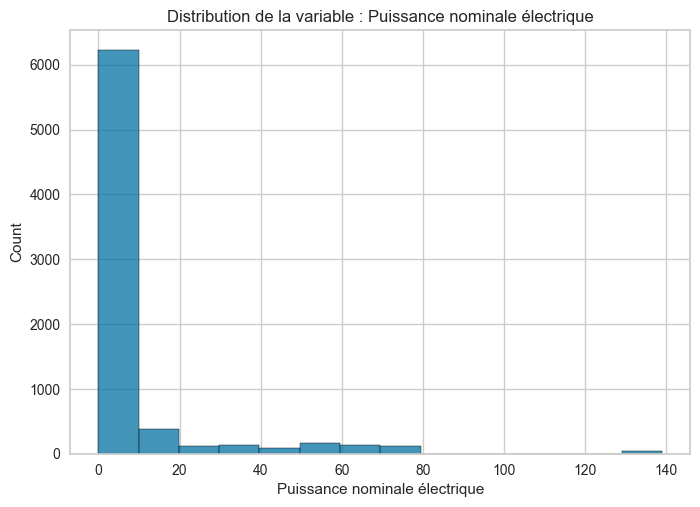

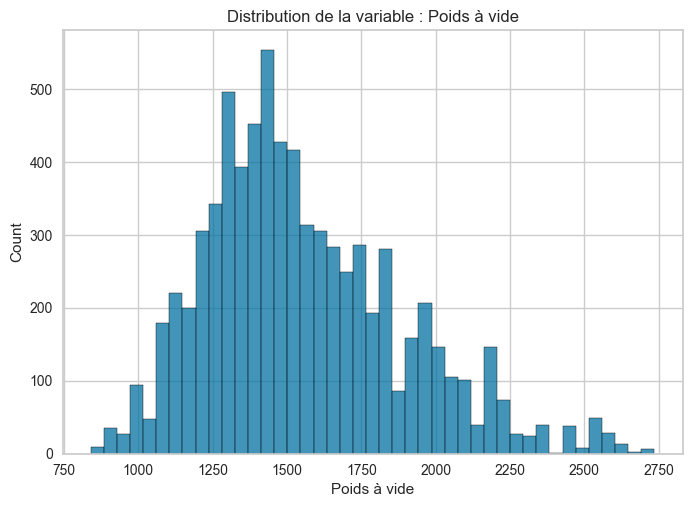

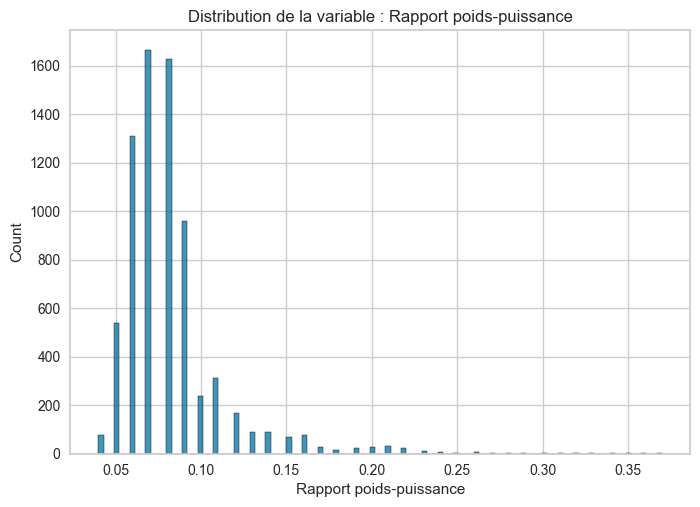

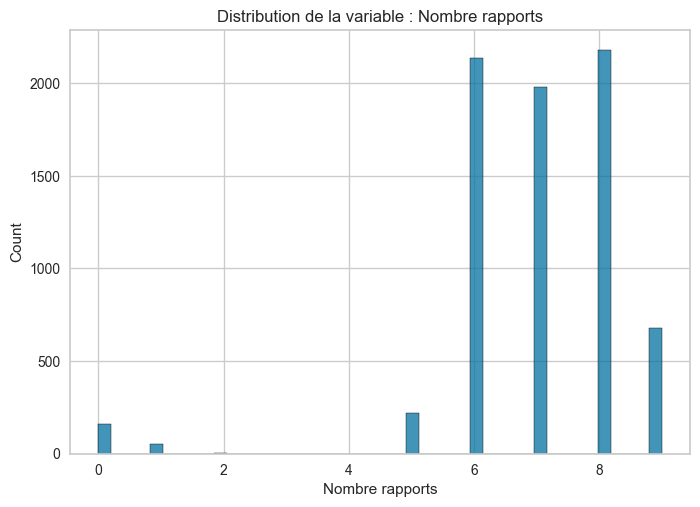

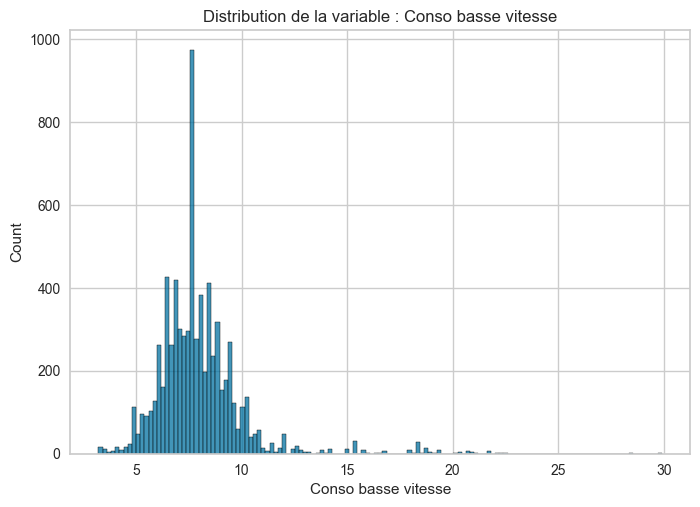

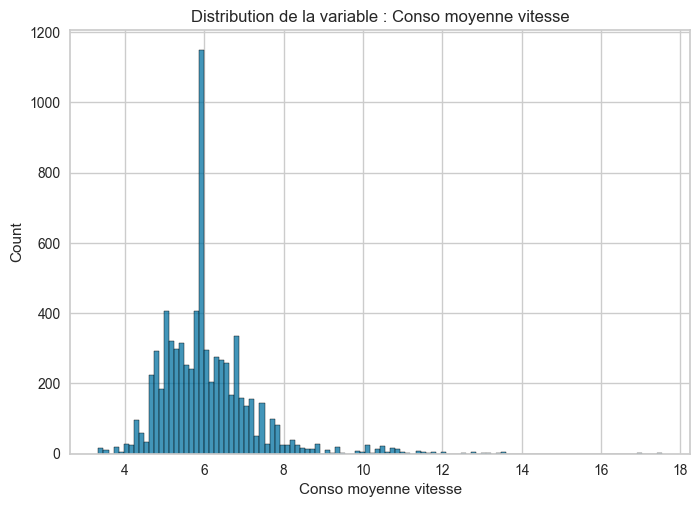

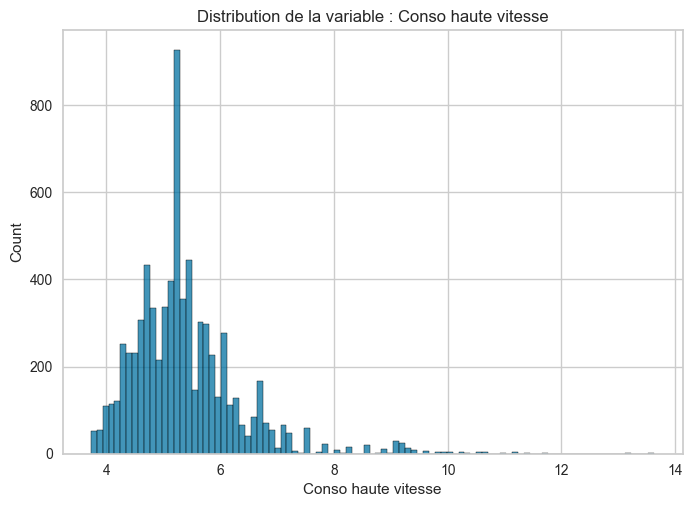

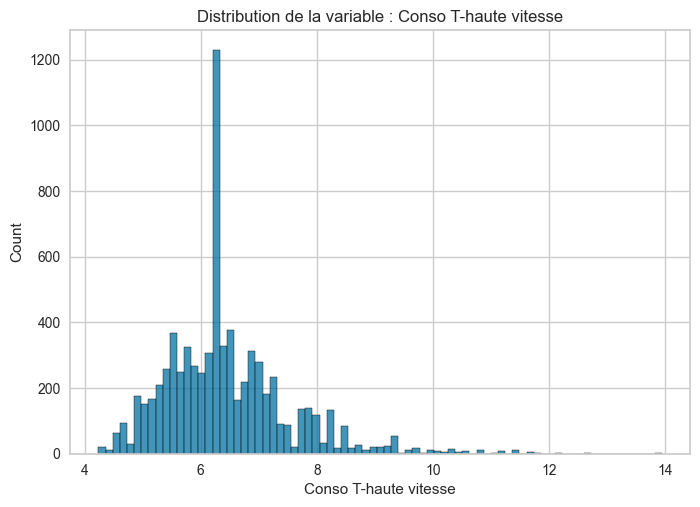

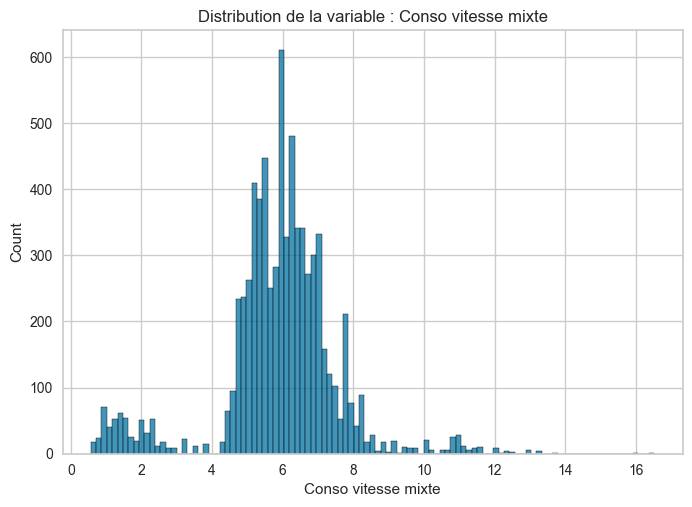

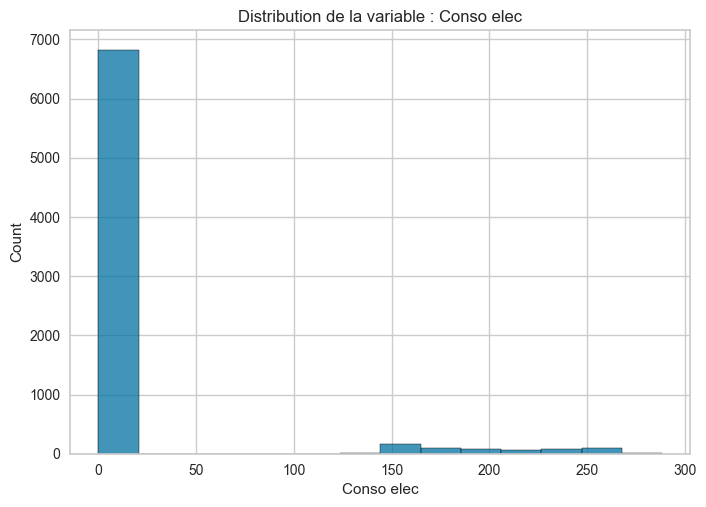

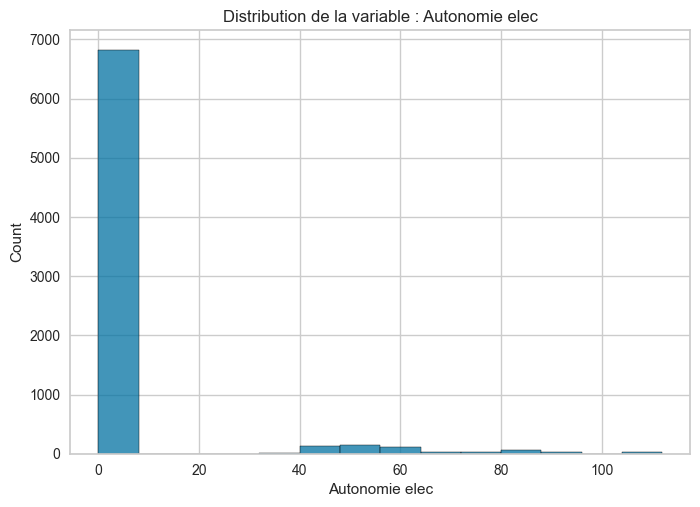

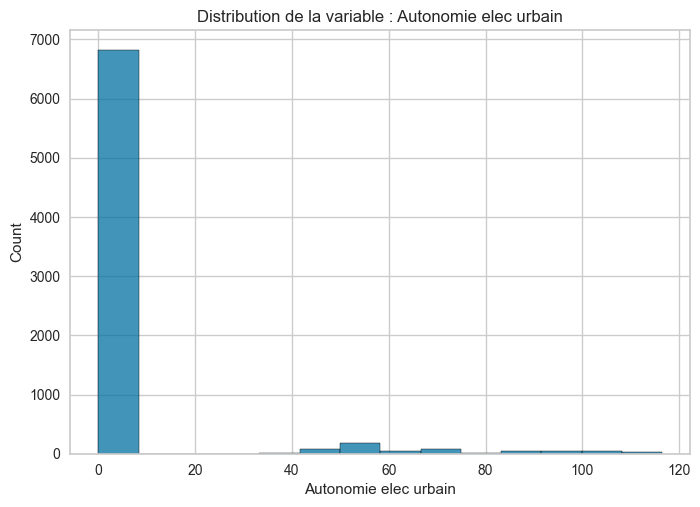

In [24]:
for col in numerical:
    sns.histplot(
        x=col,
        data=df
        )
    plt.title(f"Distribution de la variable : {col}")
    plt.show()

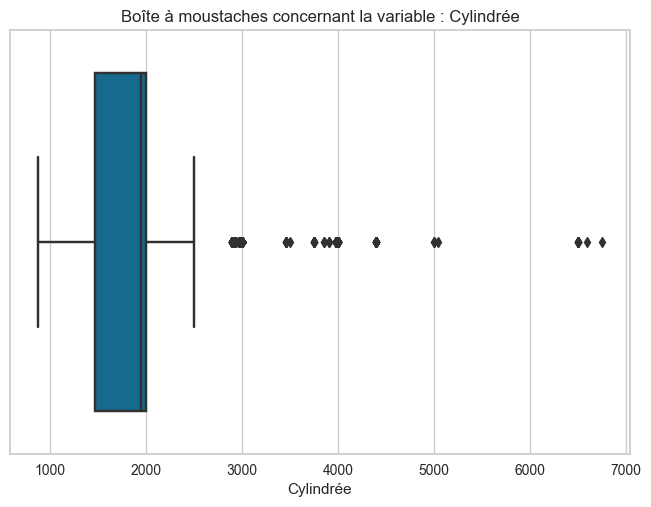

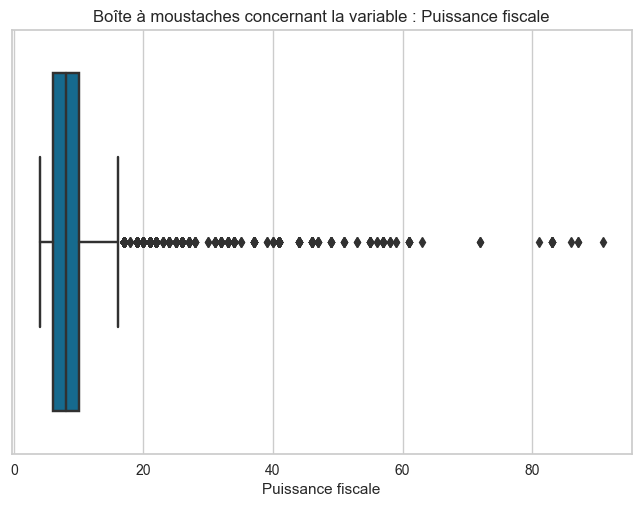

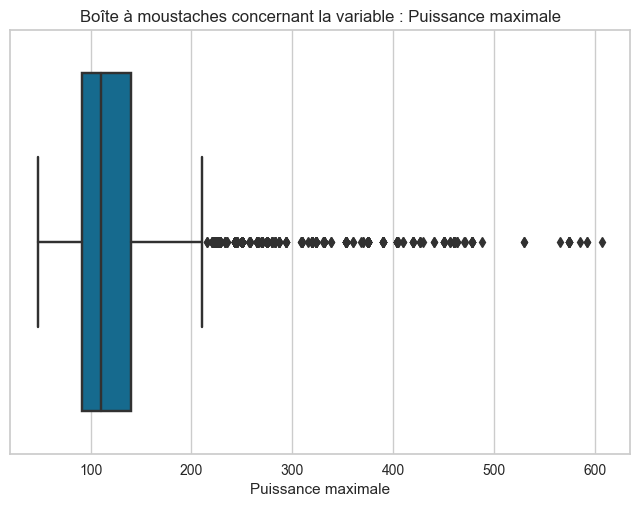

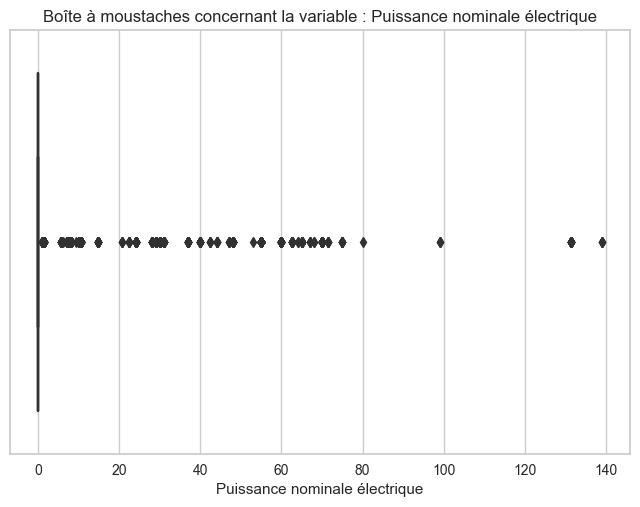

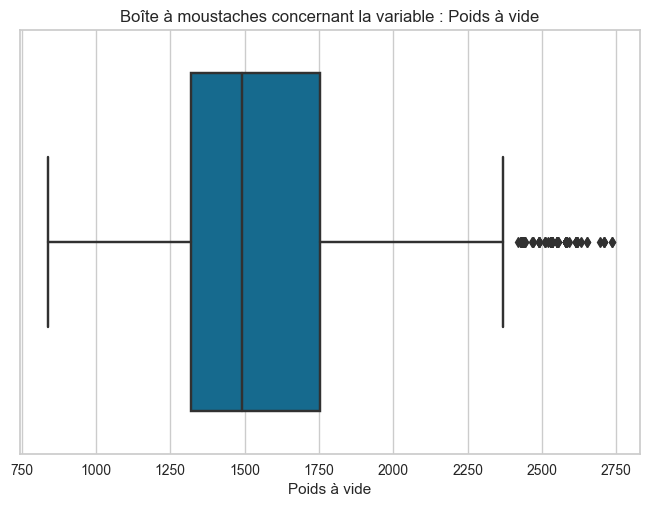

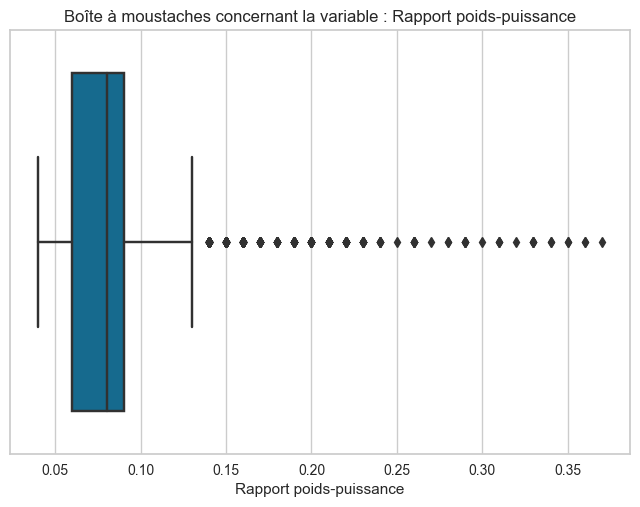

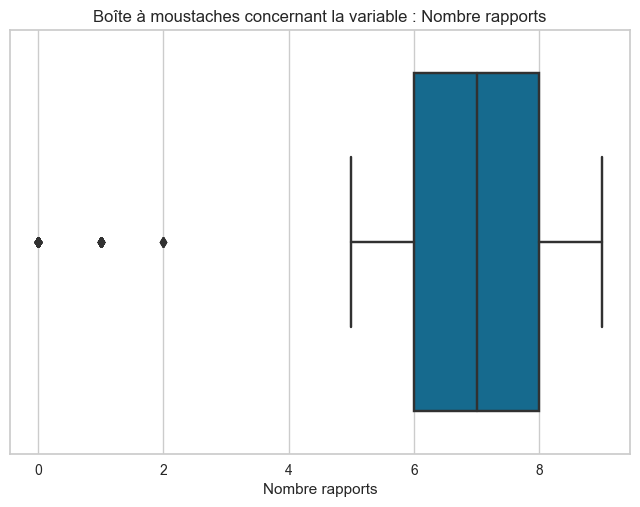

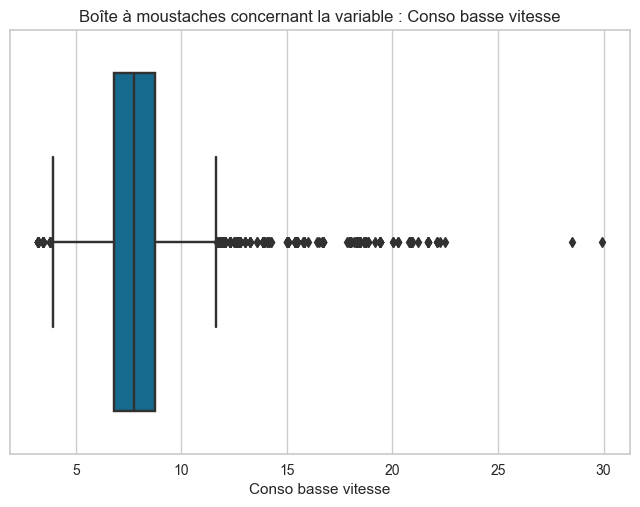

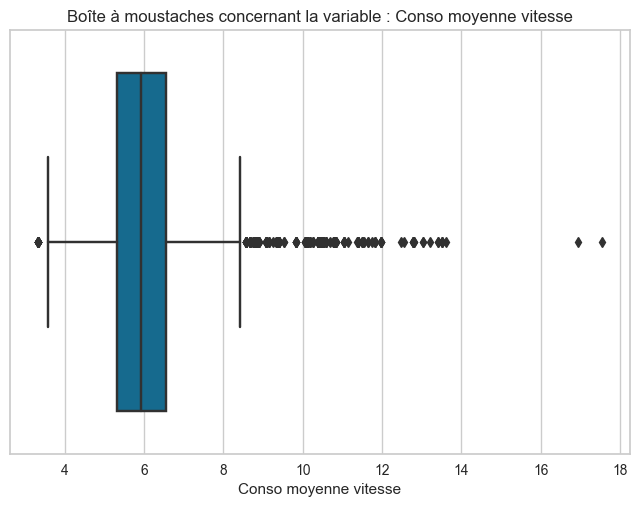

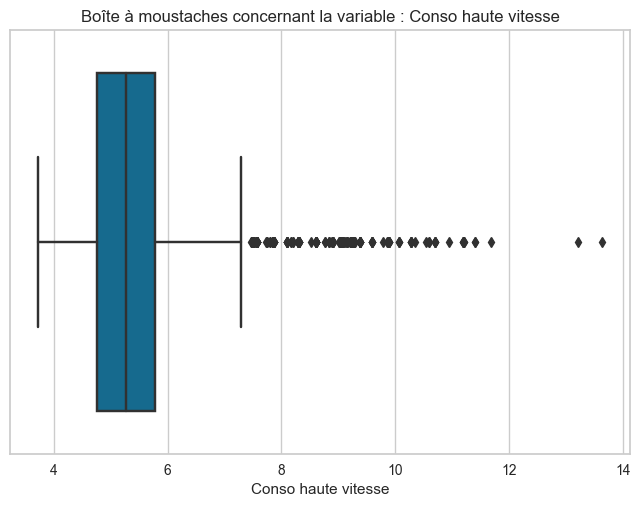

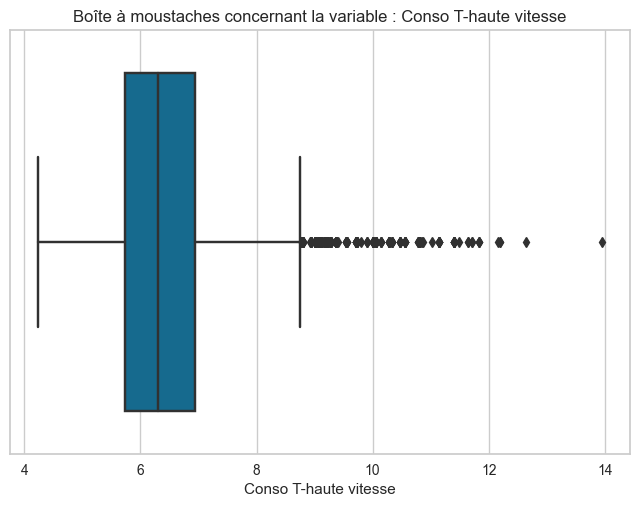

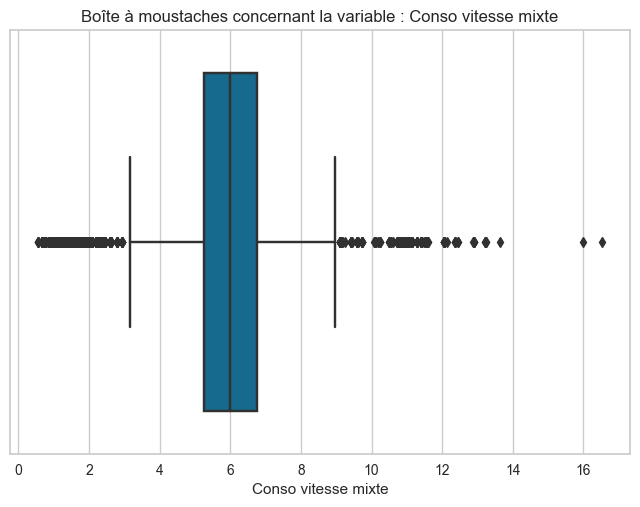

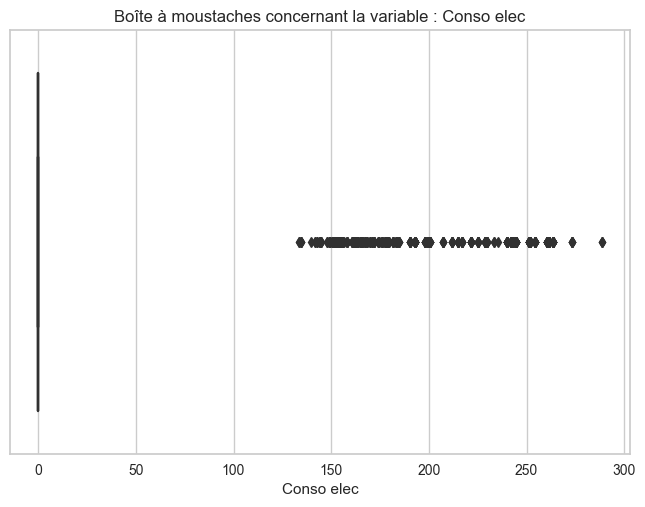

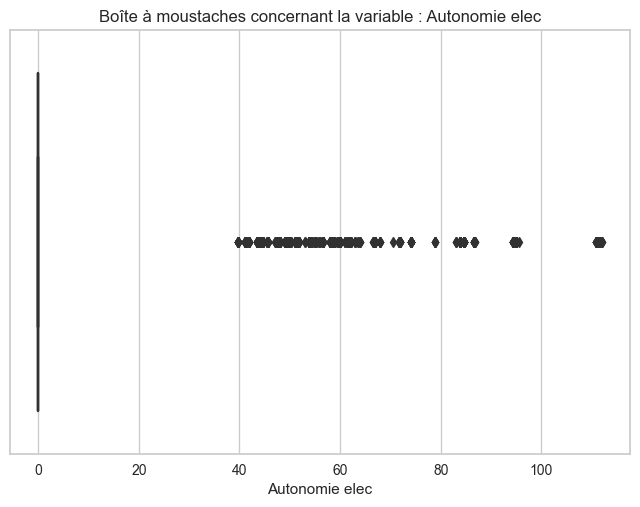

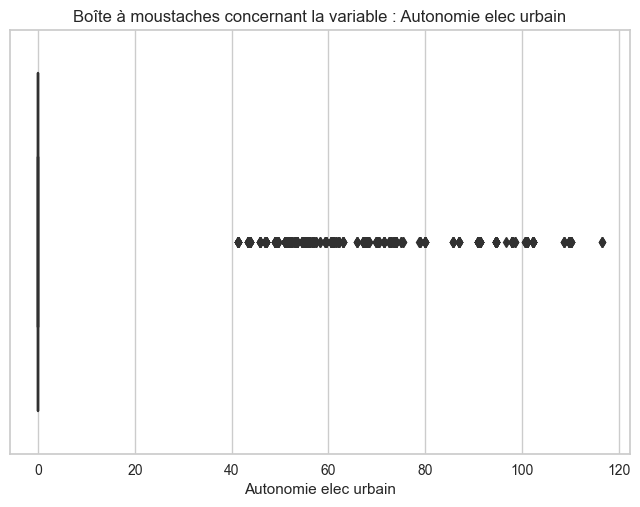

In [25]:
for col in numerical:
    sns.boxplot(
        x = col,
        data = df
        )
    plt.title(f"Boîte à moustaches concernant la variable : {col}")
    plt.show()

In [26]:
df[numerical].describe()

,Cylindrée,Puissance fiscale,Puissance maximale,Puissance nominale électrique,Poids à vide,Rapport poids-puissance,Nombre rapports,Conso basse vitesse,Conso moyenne vitesse,Conso haute vitesse,Conso T-haute vitesse,Conso vitesse mixte,Conso elec,Autonomie elec,Autonomie elec urbain
count,7409.000000,7409.000000,7409.000000,7409.000000,7409.000000,7409.000000,7409.000000,7409.000000,7409.000000,7409.000000,7409.000000,7409.000000,7409.000000,7409.000000,7409.000000
mean,1796.202322,10.229856,130.021055,6.757998,1555.344986,0.082061,6.928195,7.994275,6.059746,5.394037,6.447842,5.898809,16.028831,4.950236,5.455918
std,609.909070,7.806961,66.386992,18.413563,333.232021,0.031618,1.553918,2.128792,1.192675,0.977377,1.080364,1.704561,55.477397,17.564573,19.324330
min,875.000000,4.000000,48.000000,0.000000,840.000000,0.040000,0.000000,3.219000,3.327000,3.726000,4.238500,0.562000,0.000000,0.000000,0.000000
25%,1469.000000,6.000000,91.900000,0.000000,1320.000000,0.060000,6.000000,6.807000,5.308500,4.761000,5.733500,5.256000,0.000000,0.000000,0.000000
50%,1950.000000,8.000000,110.000000,0.000000,1490.000000,0.080000,7.000000,7.765000,5.912500,5.267500,6.296000,5.987000,0.000000,0.000000,0.000000
75%,1995.000000,10.000000,140.000000,0.000000,1755.000000,0.090000,8.000000,8.740500,6.555000,5.778500,6.940000,6.746500,0.000000,0.000000,0.000000
max,6749.000000,91.000000,607.000000,139.000000,2735.000000,0.370000,9.000000,29.914500,17.541500,13.632000,13.947000,16.521500,288.500000,112.000000,116.500000


In [27]:
numerical.append("Emission CO2")

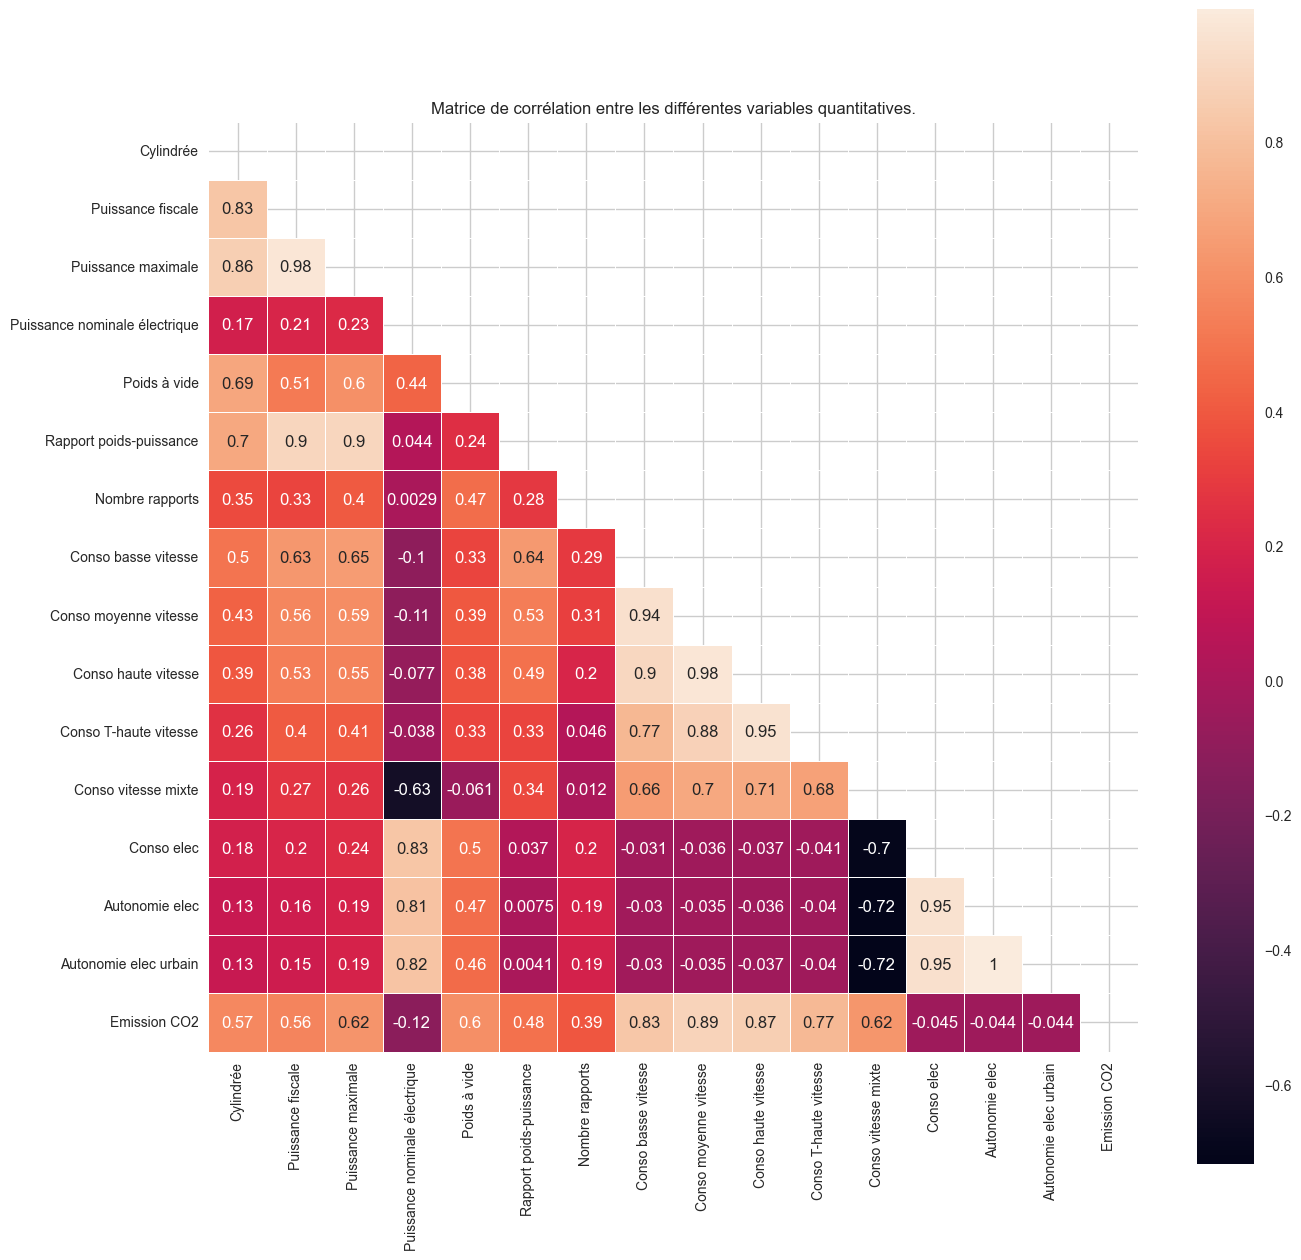

In [28]:
corr_matrix = df[numerical].corr()
mask = np.triu(corr_matrix)

plt.figure(figsize=(15,15))
sns.heatmap(corr_matrix, 
            mask=mask, 
            linewidths=.5, 
            annot=True, 
            cbar=True, 
            square=True)
plt.title("Matrice de corrélation entre les différentes variables quantitatives.")
plt.show()

In [29]:
# removing variables with poor correlation coefficient
del df["Puissance nominale électrique"]
del df["Conso elec"]
del df["Autonomie elec"]
del df["Autonomie elec urbain"]

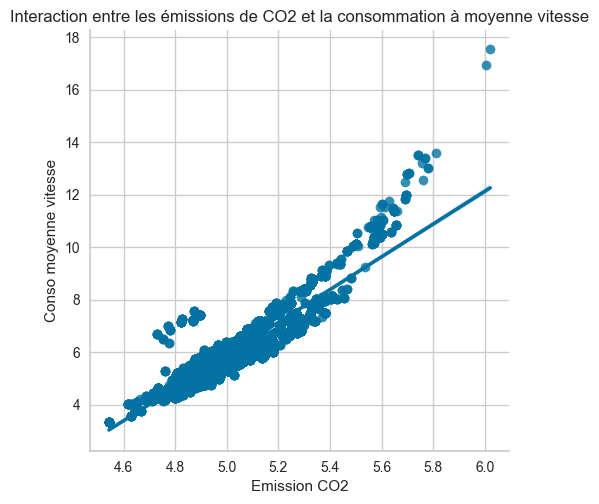

In [30]:
# plot interaction between target and most important correlation variables
sns.lmplot(
    data=df,
    x="Emission CO2",
    y="Conso moyenne vitesse"
    )
plt.title("Interaction entre les émissions de CO2 et la consommation à moyenne vitesse")
plt.show()

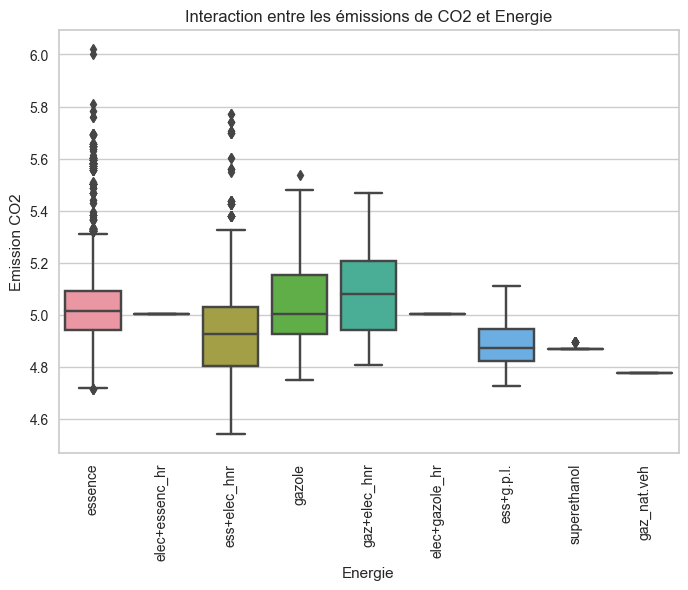

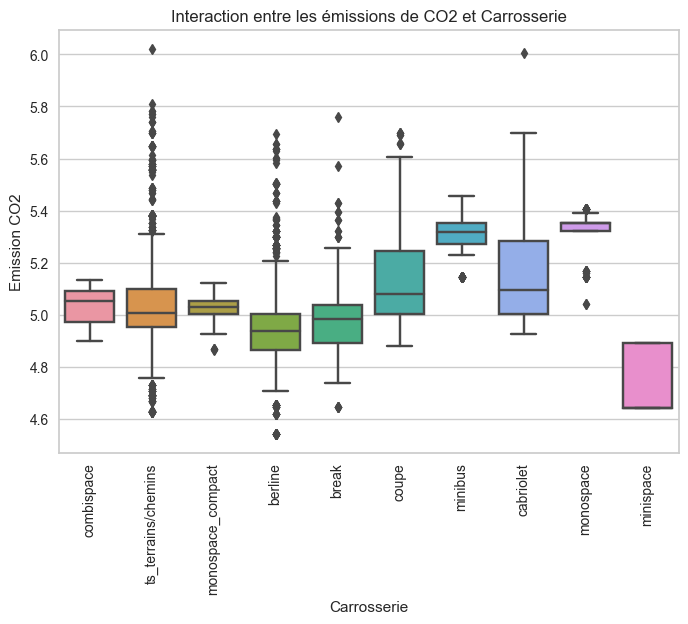

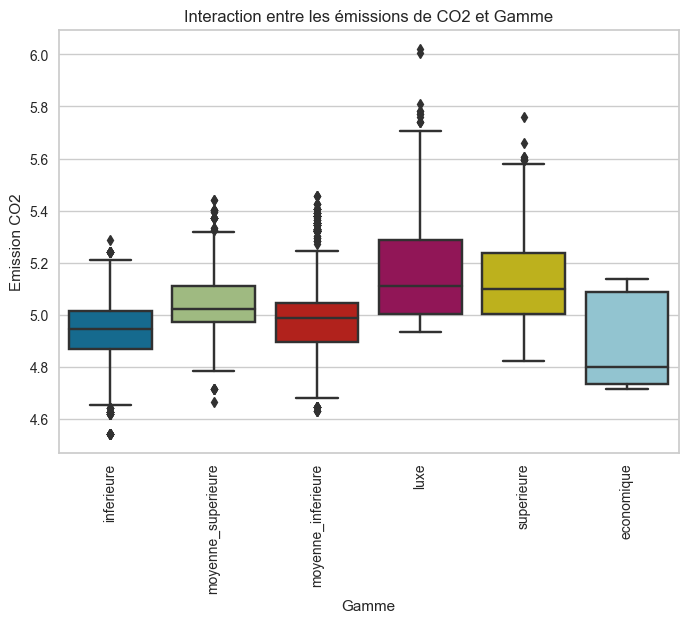

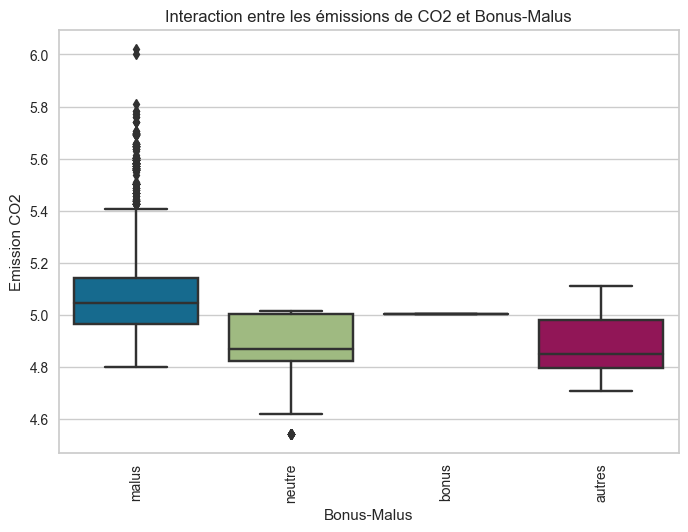

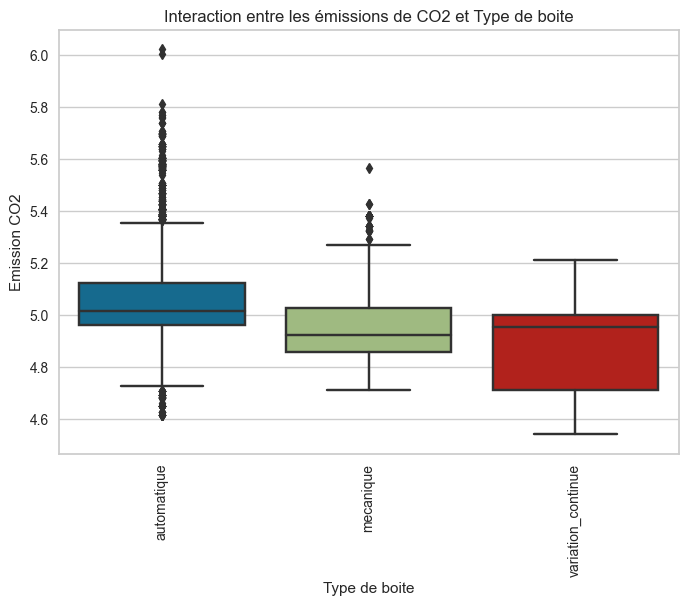

In [31]:
for col in ['Energie', 'Carrosserie', 'Gamme', 'Bonus-Malus', "Type de boite"]:
    sns.boxplot(
        data=df,
        x=col, 
        y="Emission CO2"
        )
    plt.title(f"Interaction entre les émissions de CO2 et {col}")
    plt.xticks(rotation=90)
    plt.show()

In [32]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [33]:
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [34]:
y_train = df_train["Emission CO2"].values
y_test = df_test["Emission CO2"].values

In [35]:
del df_train['Emission CO2']
del df_test['Emission CO2']

In [36]:
numerical = [i for i in list(df.columns) if i not in categorical]
numerical.pop(-1)

'Emission CO2'

In [37]:
train_dicts = df_train.to_dict(orient='records')
test_dicts = df_test.to_dict(orient='records')

In [38]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
X_test = dv.transform(test_dicts)

In [39]:
dummy = DummyRegressor(strategy="median")
dummy.fit(X_train, y_train)

DummyRegressor(strategy='median')

In [40]:
y_pred = dummy.predict(X_test)

In [41]:
rmse = round(np.sqrt(mean_squared_error(y_test, y_pred)), 5)
mape = round(mean_absolute_percentage_error(y_test, y_pred), 5)
print(f"rmse : {rmse} & mape : {mape}")

rmse : 0.17302 & mape : 0.02332


In [42]:
del y_pred
del rmse
del mape
gc.collect()

90625

In [55]:
rf = RandomForestRegressor(random_state=42, 
                           n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [56]:
y_pred = rf.predict(X_test)

In [57]:
rmse = round(np.sqrt(mean_squared_error(y_test, y_pred)), 5)
mape = round(mean_absolute_percentage_error(y_test, y_pred), 5)
print(f"rmse : {rmse} & mape : {mape}")

rmse : 0.00389 & mape : 0.00013


In [58]:
param_distribs = {
    "n_estimators" : [int(x) for x in np.linspace(50, 500, 10)],
    "max_depth" : [int(x) for x in np.linspace(5, 16, 10)],
    "min_samples_leaf" : randint(2, 10),
    "min_samples_split" : randint(2, 10),
    "bootstrap" : [True, False]
    
}

rf_rnd_search = RandomizedSearchCV(rf, 
                                   param_distributions=param_distribs,
                                   n_iter=100,
                                   cv=5,
                                   scoring="neg_mean_squared_error",
                                   random_state=42)
rf_rnd_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=100,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 6, 7, 8, 9, 11, 12, 13,
                                                      14, 16],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000020EAAB0DD10>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000020EAA6E2AD0>,
                                        'n_estimators': [50, 100, 150, 200, 250,
                                                         300, 350, 400, 450,
                                                         500]},
                   random_state=42, scoring='neg_mean_squared_error')

In [59]:
rf_rnd_search.best_params_

{'bootstrap': True,
 'max_depth': 12,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 150}

In [60]:
params = [{
    "n_estimators" : [100, 110, 120, 130,\
                      140, 150, 160, 170],
    "max_depth" : [8, 9, 10, 11, 12],
    "min_samples_leaf" : [2, 3, 4, 5],
    "min_samples_split" : [2, 3, 4, 5],
    "bootstrap" : [True]
}]

rf_grid_search = GridSearchCV(rf, 
                            params,
                            cv=5,
                            scoring="neg_mean_squared_error")
rf_grid_search.fit(X_train, 
                   y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
             param_grid=[{'bootstrap': [True], 'max_depth': [8, 9, 10, 11, 12],
                          'min_samples_leaf': [2, 3, 4, 5],
                          'min_samples_split': [2, 3, 4, 5],
                          'n_estimators': [100, 110, 120, 130, 140, 150, 160,
                                           170]}],
             scoring='neg_mean_squared_error')

In [61]:
rf_grid_search.best_params_

{'bootstrap': True,
 'max_depth': 12,
 'min_samples_leaf': 2,
 'min_samples_split': 3,
 'n_estimators': 110}

In [62]:
rf = rf_grid_search.best_estimator_

In [63]:
y_pred = rf.predict(X_test)

In [64]:
rmse = round(np.sqrt(mean_squared_error(y_test, y_pred)), 5)
mape = round(mean_absolute_percentage_error(y_test, y_pred), 5)
print(f"rmse : {rmse} & mape : {mape}")

rmse : 0.00528 & mape : 0.00022


In [67]:
df_importances = pd.DataFrame()
df_importances['feature'] = dv.feature_names_
df_importances['importance'] = rf.feature_importances_
df_importances.sort_values(by="importance", ascending=False).head(10)

,feature,importance
17,Conso moyenne vitesse,0.674538
340,Poids à vide,0.122240
18,Conso vitesse mixte,0.080200
16,Conso haute vitesse,0.041907
2,Bonus-Malus=malus,0.022563
19,Cylindrée,0.022262
15,Conso basse vitesse,0.014181
3,Bonus-Malus=neutre,0.006949
14,Conso T-haute vitesse,0.005246
342,Puissance maximale,0.001931
